# Collaboration recommender system 2.0

## **Setting up environment**

---



### **Package installation**

Installing `torch` and `torch_geometric` libraries.

In [1]:
import torch
import os
os.environ['TORCH'] = torch.__version__
print(os.environ['TORCH'])

2.4.0+cpu


### **Loading libraries**

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath(".."))

# PyTorch imports
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Embedding

# PyTorch Geometric imports
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric import EdgeIndex
from torch_geometric.loader import LinkNeighborLoader, NeighborLoader
from torch_geometric.nn import SAGEConv, HeteroConv, to_hetero, MIPSKNNIndex, Linear
from torch_geometric.data import HeteroData, Batch
from torch_geometric.nn.models.lightgcn import BPRLoss
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.metrics import (
    LinkPredPrecision,
    LinkPredRecall,
    LinkPredMAP,
    LinkPredMRR,
    LinkPredNDCG
    )


# Other imports
import io
import datetime
import math
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from box import Box
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from util.postgres import create_sqlalchemy_engine, query

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(torch_geometric.__version__)
print(f"Device: '{device}'")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

2.4.0+cpu
2.7.0
Device: 'cpu'


### **Global variables**

In [22]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yaml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)

num_recommendations = 10    # Number of recommendations
num_train = 0.8             # Percentage of data used for training
learning_rate = 1e-2        # Learning rate
num_epochs = 20            # Number of epochs
hidden_channels = 128       # Number of hidden channels

target_edge_type = ('author', 'co_authors', 'author')
target_node_type = 'author'

pg_engine = create_sqlalchemy_engine(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)
batch_size = 10000

## **Data preparation**

---



### **Loading data**

When loading the data, we take into account only the articles, where at least one author comes from the EUTOPIA

In [5]:
%%time
# Get all authors data and value metrics about their collaboration
author_query = f"""
SELECT *
FROM g_eucoht_node_author
"""
with pg_engine.connect() as conn:
    author_df = query(conn=conn, query_str=author_query)

conn.close()
author_df.head(5)

CPU times: user 51.9 ms, sys: 10.4 ms, total: 62.3 ms
Wall time: 156 ms


,author_id,dummy_feature
0,0000-0001-6379-2381,1
1,0000-0001-7809-8050,1
2,0000-0001-8367-5465,1
3,0000-0001-8606-6825,1
4,0000-0001-8718-9819,1


In [6]:
%%time
# Get all authors data and value metrics about their collaboration
published_query = f"""
SELECT *
FROM g_eucoht_edge_publishes
"""
with pg_engine.connect() as conn:
    published_df = query(conn=conn, query_str=published_query)

conn.close()
published_df.head(5)

CPU times: user 986 ms, sys: 203 ms, total: 1.19 s
Wall time: 1.37 s


,author_id,article_id,time
0,23037324500,0013330732,20180206
1,6507696573,0013330732,20180206
2,0000-0003-4842-5676,10.1002/aenm.201301688,20140101
3,14822457300,10.1002/cmdc.201402459,20141217
4,0000-0001-7809-8050,10.1002/cplu.201402054,20140101


In [7]:
%%time
# Get all authors data and value metrics about their collaboration
coauthored_query = f"""
SELECT *
FROM g_eucoht_edge_co_authors
"""
with pg_engine.connect() as conn:
    coauthored_df = query(conn=conn, query_str=coauthored_query)

conn.close()
coauthored_df.head(5)

CPU times: user 146 ms, sys: 16.2 ms, total: 163 ms
Wall time: 197 ms


,author_id,co_author_id,time,eutopia_collaboration_count
0,0000-0001-8367-5465,0000-0001-9448-789X,20050101,0
1,0000-0001-9448-789X,0000-0001-8367-5465,20050101,0
2,0000-0003-3517-3780,6506321882,20120101,0
3,10040417200,8221262000,20090101,0
4,10040997700,18233779900,20091101,0


In [8]:
%%time
with pg_engine.raw_connection().cursor() as cur:
    article_query = f"""
    SELECT article_id,
           article_citation_normalized_count,
           is_eutopia_collaboration,
           collaboration_novelty_index,
           article_embedding
    FROM g_eucoht_node_article
    """
    cur.execute(article_query)
    # Initialize the Polars DataFrame
    article_df_polars: pl.DataFrame = pl.DataFrame()
    ix = 0
    # Fetch in chunks
    while True:
        rows = cur.fetchmany(size=batch_size)
        if not rows:
            break
        # Append the rows to the Polars DataFrame
        df_chunk = pl.DataFrame(rows, schema=[
            "article_id", 
            "article_citation_normalized_count",
            "is_eutopia_collaboration",
            "collaboration_novelty_index",
            "article_embedding"
        ], orient="row")
    
        # Concatenate chunk with the master DataFrame
        article_df_polars = pl.concat([article_df_polars, df_chunk], how="vertical")
        print(f"Rows fetched {batch_size} for batch {ix}")
        ix += 1

article_df = article_df_polars.to_pandas()
article_df.head(5)

Rows fetched 10000 for batch 0
Rows fetched 10000 for batch 1
Rows fetched 10000 for batch 2
Rows fetched 10000 for batch 3
Rows fetched 10000 for batch 4
Rows fetched 10000 for batch 5
CPU times: user 33.7 s, sys: 8.88 s, total: 42.6 s
Wall time: 1min 4s


,article_id,article_citation_normalized_count,is_eutopia_collaboration,collaboration_novelty_index,article_embedding
0,84865405594,20.42,0,0.861111,"[0.004589761607348919, 0.02756412886083126, -0..."
1,84880929267,1.37,0,0.500070,"[0.010607256554067135, 0.027150079607963562, -..."
2,77952382135,4.29,0,3.000000,"[-0.006951452698558569, -0.0008734843577258289..."
3,77954866153,6.23,0,0.770833,"[0.005069693550467491, 0.007222142070531845, -..."
4,85030783799,1.42,0,2.000000,"[-0.01370143610984087, 0.01628061570227146, 0...."


### Contiguous unique identifier for node: **author**

In [9]:
# Author: Map each unique MD5 hash to a contiguous unique integer ID
unique_authors = author_df['author_id'].unique()
author_id_map = {author: i for i, author in enumerate(unique_authors)}
author_sid_map = {y: x for x, y in author_id_map.items()}
# ---> Adjust all dataframes
author_df['author_node_id'] = author_df['author_id'].map(author_id_map)
published_df['author_node_id'] = published_df['author_id'].map(author_id_map)
coauthored_df['author_node_id'] = coauthored_df['author_id'].map(author_id_map)
coauthored_df['co_author_node_id'] = coauthored_df['co_author_id'].map(author_id_map)

### Contiguous unique identifier for node: **article**

In [10]:
# Article: Map each unique MD5 hash to a contiguous unique integer ID
unique_articles = published_df['article_id'].unique()
article_id_map = {article: i for i, article in enumerate(unique_articles)}
article_sid_map = {y: x for x, y in article_id_map.items()}
# ---> Adjust all dataframes
article_df['article_node_id'] = article_df['article_id'].map(article_id_map)
published_df['article_node_id'] = published_df['article_id'].map(article_id_map)

## **Heterogeneous graph creation**
First of all, we prepare the node features for articles. We first sort the article dataframe by node ID. We know that we have unique values in the article dataframe, i.e. one row per article and we can just sort it. Otherwise, we would need to create a unique mapping between article features and articles themselves. The sorting needs to match the node index that we will create later. After that, we also need to set up correct type (specifically, convert Pandas Int64 to int64, but we go for the lazy version and just convert all features to float64). At last, we exclude the `ARTICLE_SID` and `ARTICLE_NODE_ID` columns, because Torch can't work with strings.

**TODO:**
- Think about only including "valuable" partnerships/edges.

### Matrix X for node: **article**

In [11]:
# Article X
# Sort article dataframe
sorted_article_df = article_df.sort_values(by='article_node_id')
article_x_columns = list(filter(lambda x: x not in ('article_id', 'article_node_id', 'article_embedding'), sorted_article_df.columns))

# Convert EMBEDDING_TENSOR_DATA to proper format
embedding_tensor = np.stack(sorted_article_df['article_embedding'].values)
embedding_tensor = torch.tensor(embedding_tensor, dtype=torch.float)

# Convert types
article_x = sorted_article_df[article_x_columns].astype('float32').values

# Append embedding_tensor to article_x
article_x = np.concatenate((article_x, embedding_tensor), axis=1)

# Normalize X using std scaler
article_x = StandardScaler().fit_transform(article_x)

### Matrix X for node: **author**

In [12]:
# Author X
# Sort author dataframe
sorted_author_df = author_df.sort_values(by='author_node_id')
# Exclude columns AUTHOR_SID, AUTHOR_NODE_ID
author_x_columns = list(filter(lambda x: x not in ('author_id', 'author_node_id'), sorted_author_df.columns))
# Convert types
author_x = sorted_author_df[author_x_columns].astype('float32').values

# Normalize X using std scaler
author_x = StandardScaler().fit_transform(author_x)

### Edge index for edge: **(author, publishes, article)**

In [13]:
# Add edge index: for edges corresponding to authors publishing articles (author to article connection)
author_node_ids = torch.from_numpy(published_df['author_node_id'].values)
article_node_ids = torch.from_numpy(published_df['article_node_id'].values)
edge_index_publishes = torch.stack([author_node_ids, article_node_ids], dim=0)
edge_time_publishes = torch.from_numpy(np.array(published_df['time'].values.astype('int64')))

### Edge index for edge: **(author, co_authors, author)**

In [14]:
# Add edge index: for edges corresponding to authors co-authoring articles (author to author connection)
author_node_ids = torch.from_numpy(coauthored_df['author_node_id'].values)
coauthor_node_ids = torch.from_numpy(coauthored_df['co_author_node_id'].values)
edge_index_co_authors = torch.stack([author_node_ids, coauthor_node_ids], dim=0)
edge_time_co_authors = torch.from_numpy(np.array(coauthored_df['time'].values.astype('int64')))

### Data object

After generating the initial node feature Numpy array, we create an instance of `HeteroData` class with two types of nodes corresponding to authors and articles and an edge denoting authors publishing articles.

*Note: We also need to make sure to add the reverse edges from authors to aritcles in order to let a GNN be able to pass messages in both directions. We can leverage the `T.ToUndirected()` transform for this from PyG.*

In [15]:
data = HeteroData()

# Save node indices:
data["article"].node_id = torch.arange(len(unique_articles))
data["author"].node_id = torch.arange(len(unique_authors))
# Add edge 'published'
data["author", "publishes", "article"].edge_index = edge_index_publishes
data["author", "publishes", "article"].time = edge_time_publishes
# Add edge 'co_authors'
data[('author', 'co_authors', 'author')].edge_index = edge_index_co_authors
data[('author', 'co_authors', 'author')].time = edge_time_co_authors

# Set X for article
data["article"].x = torch.from_numpy(article_x)
# Set X for author
data["author"].x = torch.from_numpy(author_x)

# Reverse edges
data = T.ToUndirected(reduce='min')(data)
data

HeteroData(
  article={
    node_id=[55076],
    x=[55076, 771],
  },
  author={
    node_id=[7734],
    x=[7734, 1],
  },
  (author, publishes, article)={
    edge_index=[2, 124874],
    time=[124874],
  },
  (author, co_authors, author)={
    edge_index=[2, 28210],
    time=[28210],
  },
  (article, rev_publishes, author)={
    edge_index=[2, 124874],
    time=[124874],
  }
)

In [16]:
data.x_dict

{'article': tensor([[-0.1702, -0.1677, -0.0535,  ..., -1.5174,  0.4311,  1.0342],
         [ 0.7226, -0.1677, -0.1208,  ..., -0.0900,  2.0186,  0.2434],
         [ 0.2148, -0.1677, -0.1208,  ...,  0.1781,  1.6704, -0.6084],
         ...,
         [-0.1976, -0.1677,  0.0035,  ..., -0.7453, -0.5125, -0.5808],
         [-0.1976, -0.1677, -0.1829,  ...,  0.4680,  0.8709,  1.5607],
         [-0.1976, -0.1677, -0.0820,  ...,  0.6162,  0.6727,  0.2975]]),
 'author': tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]])}

## Heterogeneous graph batching

###  Split data to train, test

In [17]:
edge_types = data.metadata()[1]

time = data[target_edge_type].time
perm = time.argsort()
# Find minimum time in `co_authors` edge that still resides in test set
test_min_time = time[perm[int(num_train * perm.numel()):]].min()

for edge_type in edge_types:
  # Define the training dataset for all edge types
  time = data[edge_type].time
  data[edge_type].train_mask = time < test_min_time
  data[edge_type].train_edge_index = data[edge_type].edge_index[:, data[edge_type].train_mask]
  data[edge_type].train_edge_time = time[data[edge_type].train_mask]

data.train_edge_index_dict = {edge_type: data[edge_type].train_edge_index for edge_type in edge_types}

# Add test dataset for `co_authors` edge type
data[target_edge_type].test_mask = data[target_edge_type].time >= test_min_time
data[target_edge_type].test_pos_edge_index = data[target_edge_type].edge_index[:, data[target_edge_type].test_mask]
data[target_edge_type].test_edge_time = data[target_edge_type].time[data[target_edge_type].test_mask]


# Negative sampling
test_neg_edge_index_i, test_neg_edge_index_j, test_neg_edge_index_k = structured_negative_sampling(
    edge_index=data[target_edge_type].test_pos_edge_index,
    num_nodes=data[target_node_type].num_nodes)
test_neg_edge_index = torch.stack([test_neg_edge_index_i, test_neg_edge_index_k], dim=0)
# Add negative samples to test data
data[target_edge_type].test_neg_edge_index = test_neg_edge_index


### Data loader (mini-batching)

After splitting the data, we need to take into account that we are dealing with very large graphs. A simple load of data to GPU will already return `CUDA out of memory` exception. Hence, we use mini-batching to appropriately split the edges (regardless if we are in training, testing or validation phase). This process will separate the large graph into multiple smaller graphs and process them independently, thus fixing the out-of-memory exceptions.


## Model training


---



### Model definition

Our model consists of two parts, first we must encode our nodes using the message passing algorithm exploiting both (author, co-authors, author) and (author, publishes, article) edges and corresponding node features. The second part decodes the edges that the model outputs as its prediction using two simple, fully-connected, linear layers.

**TODO:**
- Promote EUTOPIA-an collaborations or even restrict to EUTOPIA-an collaborations.

In [57]:
from typing import Optional, Union
from torch_geometric.nn import HANConv

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Embedding, ModuleList
from torch.nn.modules.loss import _Loss

from torch_geometric.nn.conv import GATv2Conv,GCNConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.utils import is_sparse, to_edge_index
from torch_geometric.nn.models.lightgcn import BPRLoss

class Encoder(torch.nn.Module):
    def __init__(self, hidden_channels: int, 
                 num_layers: int = 4):
        super().__init__()

        self.num_layers = num_layers
        # Define multiple HANConv layers:
        self.conv_layers = ModuleList([
            HANConv(
                in_channels=(-1),
                out_channels=hidden_channels,
                metadata=data.metadata(),
                heads=4,
                dropout=0.5
            )
            for i in range(self.num_layers)
        ])

        # Linear layers (for skips)
        self.linear_layers = dict(
            author=ModuleList([
                Linear(-1, hidden_channels)
                for i in range(self.num_layers)
            ]),
            article=ModuleList([
                Linear(-1, hidden_channels)
                for i in range(self.num_layers)
                ])
        )
        
        self.bn_layers = dict(
            author=ModuleList([
                torch.nn.BatchNorm1d(hidden_channels)
                for i in range(self.num_layers)
            ]),
            article=ModuleList([
                torch.nn.BatchNorm1d(hidden_channels)
                for i in range(self.num_layers)
                ])
        )

        # Initialize the alpha
        alpha = torch.ones(self.num_layers + 1) / (self.num_layers + 1)

        # Register alpha as a parameter if you want it to be learnable:
        self.alpha = alpha # nn.Parameter(alpha, requires_grad=True)   


    def forward(self, x_dict, edge_index_dict):
        out_dict = {
            ntype: torch.zeros(x.shape[0], self.conv_layers[0].out_channels, device=x.device)
            for ntype, x in x_dict.items()
        }
        
        # Keep track of current hidden states
        h_dict = x_dict
        
        for i in range(self.num_layers):
            # Apply HANConv
            new_h_dict = self.conv_layers[i](h_dict, edge_index_dict)
        
            # Add skip connection
            for ntype in new_h_dict:
                new_h_dict[ntype] = new_h_dict[ntype] + self.linear_layers[ntype][i](h_dict[ntype])
        
            # BatchNorm
            for ntype in new_h_dict:
                new_h_dict[ntype] = self.bn_layers[ntype][i](new_h_dict[ntype])

            # Accumulate in out_dict with alpha weighting
            for ntype in out_dict:
                out_dict[ntype] += self.alpha[i] * new_h_dict[ntype]
        
            # Update hidden state for next layer
            h_dict = new_h_dict
        
        return out_dict


class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, z, edge_label_index):
        out_src = z[edge_label_index[0]]
        out_dst = z[edge_label_index[1]]

        # Calculate the dot product
        return (out_src * out_dst).sum(dim=-1)

class CollaborationRecommender(torch.nn.Module):
    def __init__(self,
                 hidden_channels: int,
                 k: int,
                 alpha: Optional[Union[float, Tensor]] = None):
        super().__init__()

        self.hidden_channels = hidden_channels
        self.k = k

        self.encoder = Encoder(hidden_channels=hidden_channels)
        self.decoder = Decoder()


    def forward(self,
                x_dict,
                edge_index_dict,
                edge_label_index: OptTensor = None):

        # Encode authors
        z_dict = self.encoder(x_dict, edge_index_dict)
        z = z_dict['author']
        # Decode edges
        return self.decoder(z, edge_label_index)

    def recommend(self,
                  x_dict,
                  edge_index_dict,
                  author_sid: str,
                  k: int = 10):

        # Get all embeddings
        out_src = out_dst = self.encoder(x_dict, edge_index_dict)

        # Get the author id
        author_id = author_id_map[author_sid]
        # Get the author embedding
        out_src = out_src[author_id]

        # Calculate the dot product
        pred = out_src @ out_dst.t()
        # Get the top k recommendations
        top_index = pred.topk(k, dim=-1, sorted=True).indices

        # Decode top k recommendations to author SIDs
        top_author_sids = [author_sid_map[int(i)] for i in top_index]

        return top_author_sids


    def recommendation_loss(self,
                            x_dict,
                            edge_index_dict,
                            pos_edge_rank,
                            neg_edge_rank,
                            node_id: Optional[Tensor] = None,
                            lambda_reg: float = 1e-4):
        loss_fn = BPRLoss(lambda_reg)
        # Get the embedding
        z_dict = self.encoder(x_dict, edge_index_dict)
        emb = z_dict['author']
        # Get the loss
        emb = emb if node_id is None else emb[node_id]
        return loss_fn(pos_edge_rank, neg_edge_rank, emb)


model = CollaborationRecommender(hidden_channels=64,
                                 k=num_recommendations).to(device)

# Transfer to device
data = data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Training the model

Our model is then trained through a number of epochs, where in each epoch we perform mini-batching to avoid memory issues on GPU.


In [19]:
import pytest
from torch_geometric.metrics.link_pred import LinkPredMetric
class LinkPredHitRate(LinkPredMetric):
    higher_is_better: bool = True

    def _compute(self, pred_isin_mat: Tensor, y_count: Tensor) -> Tensor:
        return pred_isin_mat.sum(dim=-1) >= 1

def test_hit_rate():
    pred_mat = torch.tensor([[1, 0], [1, 2], [0, 2], [0, 1]])
    edge_label_index = torch.tensor([[0, 0, 2, 2, 3], [0, 1, 2, 1, 2]])

    metric = LinkPredHitRate(k=2)
    metric.update(pred_mat, edge_label_index)
    result = metric.compute()

    assert result == pytest.approx((2) / 3)

test_hit_rate()

def train():
    model.train()
    # Fetch existing graph edges as positive samples
    pos_edge_index = data[target_edge_type].train_edge_index
    # Perform structured negative sampling, meaning that for every positive sample,
    # there will be another negative sample at the same index/position
    # - this structure is expected in BPR loss calculation
    neg_edge_index_i, neg_edge_index_j, neg_edge_index_k = structured_negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=data[target_node_type].num_nodes)
    # Structure negative sampling returns both positive and negative edges, so
    # we need to concatenate appropriate nodes to get the negative edges
    neg_edge_index = torch.stack([neg_edge_index_i, neg_edge_index_k], dim=0)

    optimizer.zero_grad()

    # Concatenate edge label indices into a single edge label index
    edge_label_index = torch.cat([
        pos_edge_index,
        neg_edge_index,
    ], dim=1)

    pos_edge_rank, neg_edge_rank = model(x_dict=data.x_dict,
                                         edge_index_dict=data.train_edge_index_dict,
                                         edge_label_index=edge_label_index).chunk(2)

    # Calculate BPR loss
    loss = model.recommendation_loss(x_dict=data.x_dict,
                                     edge_index_dict=data.train_edge_index_dict,
                                     pos_edge_rank=pos_edge_rank,
                                     neg_edge_rank=neg_edge_rank,
                                     node_id=edge_label_index.unique())

    loss.backward()
    optimizer.step()

    total_loss = float(loss) * pos_edge_rank.numel()
    total_examples = pos_edge_rank.numel()

    # Cleanup
    del pos_edge_rank, neg_edge_rank
    torch.cuda.empty_cache()

    return total_loss / total_examples


@torch.no_grad()
def test():
    model.eval()

    pos_edge_index = data[target_edge_type].test_pos_edge_index
    neg_edge_index = data[target_edge_type].test_neg_edge_index

    # Concatenate edge label indices into a single edge label index
    edge_label_index = torch.cat([
        pos_edge_index,
        neg_edge_index,
    ], dim=1)

    # We encode the training edge index to get the embeddings based on the training graph
    # structure and then use those embeddings to predict unseen edges
    # TODO: Check if this makes sense
    pos_edge_rank, neg_edge_rank = model(x_dict=data.x_dict,
                                         edge_index_dict=data.train_edge_index_dict,
                                         edge_label_index=edge_label_index).chunk(2)

    # Calculate BPR loss
    loss = model.recommendation_loss(x_dict=data.x_dict,
                                     edge_index_dict=data.train_edge_index_dict,
                                     pos_edge_rank=pos_edge_rank,
                                     neg_edge_rank=neg_edge_rank,
                                     node_id=edge_label_index.unique())

    total_loss = float(loss) * pos_edge_rank.numel()
    total_examples = pos_edge_rank.numel()

    # Cleanup
    del pos_edge_rank, neg_edge_rank
    torch.cuda.empty_cache()

    return total_loss / total_examples

@torch.no_grad()
def evaluate(k:int=20):
    model.eval()
    z_dict = model.encoder(data.x_dict, data.train_edge_index_dict)
    embs = z_dict[target_node_type].to(device)

    result = {
        'precision@k': LinkPredPrecision(k=k).to(device),
        'recall@k': LinkPredRecall(k=k).to(device),
        'map@k': LinkPredMAP(k=k).to(device),
        'mrr@k': LinkPredMRR(k=k).to(device),
        'ndcg@k': LinkPredNDCG(k=k).to(device),
        'hit_rate@k': LinkPredHitRate(k=k).to(device)
        }

    # Calculate distance between embeddings
    logits = embs @ embs.T

    # Exclude training edges
    logits[data[target_edge_type].train_edge_index[0], data[target_edge_type].train_edge_index[1]] = float('-inf')

    # Gather ground truth data
    ground_truth = data[target_edge_type].test_pos_edge_index

    # Get top-k recommendations for each node
    top_k_index = torch.topk(logits, k=k, dim=1).indices

    # Update performance metrics
    for metric in result.keys():
      result[metric].update(
          pred_index_mat=top_k_index,
          edge_label_index=ground_truth)

    # Cleanup
    del embs, logits, ground_truth, top_k_index
    torch.cuda.empty_cache()

    return result

In [58]:
results = []
for epoch in tqdm(range(1,  100 + 1)):
    train_loss = train()
    test_loss = test()
    scheduler.step(test_loss)
    eval_result = evaluate(k=num_recommendations)

    # Save results
    epoch_result = {
        'epoch': epoch  ,
        'train_loss_bpr': train_loss,
        'test_loss_bpr': test_loss,
        'precision@k': eval_result['precision@k'].compute(),
        'recall@k': eval_result['recall@k'].compute(),
        'map@k': eval_result['map@k'].compute(),
        'mrr@k': eval_result['mrr@k'].compute(),
        'ndcg@k': eval_result['ndcg@k'].compute(),
        'hit_rate@k': eval_result['hit_rate@k'].compute()
    }
    results.append(epoch_result)

    # Log results
    if epoch % 2 == 0:
        # Log model performance
        formatted_str = ', '.join([f'{key}: {epoch_result[key]:.4f}' for key in epoch_result.keys()])
        print(formatted_str)


results = pd.DataFrame(results)

  2%|▊                                          | 2/100 [00:10<08:20,  5.11s/it]

epoch: 2.0000, train_loss_bpr: 0.1052, test_loss_bpr: 1.7175, precision@k: 0.0148, recall@k: 0.0284, map@k: 0.0105, mrr@k: 0.0286, ndcg@k: 0.0218, hit_rate@k: 0.0843


  4%|█▋                                         | 4/100 [00:19<07:30,  4.70s/it]

epoch: 4.0000, train_loss_bpr: 0.0681, test_loss_bpr: 1.6173, precision@k: 0.0169, recall@k: 0.0295, map@k: 0.0112, mrr@k: 0.0307, ndcg@k: 0.0232, hit_rate@k: 0.0918


  6%|██▌                                        | 6/100 [00:34<10:35,  6.76s/it]

epoch: 6.0000, train_loss_bpr: 0.0581, test_loss_bpr: 1.5047, precision@k: 0.0180, recall@k: 0.0302, map@k: 0.0135, mrr@k: 0.0394, ndcg@k: 0.0265, hit_rate@k: 0.0960


  8%|███▍                                       | 8/100 [01:14<21:04, 13.75s/it]

epoch: 8.0000, train_loss_bpr: 0.0460, test_loss_bpr: 1.4032, precision@k: 0.0197, recall@k: 0.0375, map@k: 0.0150, mrr@k: 0.0391, ndcg@k: 0.0294, hit_rate@k: 0.1043


 10%|████▏                                     | 10/100 [01:43<20:48, 13.88s/it]

epoch: 10.0000, train_loss_bpr: 0.0403, test_loss_bpr: 1.3098, precision@k: 0.0201, recall@k: 0.0371, map@k: 0.0145, mrr@k: 0.0353, ndcg@k: 0.0285, hit_rate@k: 0.1077


 12%|█████                                     | 12/100 [01:52<13:11,  8.99s/it]

epoch: 12.0000, train_loss_bpr: 0.0364, test_loss_bpr: 1.2404, precision@k: 0.0210, recall@k: 0.0388, map@k: 0.0170, mrr@k: 0.0547, ndcg@k: 0.0330, hit_rate@k: 0.1119


 14%|█████▉                                    | 14/100 [02:26<20:09, 14.07s/it]

epoch: 14.0000, train_loss_bpr: 0.0328, test_loss_bpr: 1.1827, precision@k: 0.0206, recall@k: 0.0383, map@k: 0.0175, mrr@k: 0.0524, ndcg@k: 0.0329, hit_rate@k: 0.1110


 16%|██████▋                                   | 16/100 [02:44<15:22, 10.98s/it]

epoch: 16.0000, train_loss_bpr: 0.0312, test_loss_bpr: 1.1352, precision@k: 0.0207, recall@k: 0.0402, map@k: 0.0163, mrr@k: 0.0435, ndcg@k: 0.0315, hit_rate@k: 0.1119


 18%|███████▌                                  | 18/100 [02:52<10:20,  7.57s/it]

epoch: 18.0000, train_loss_bpr: 0.0260, test_loss_bpr: 1.0900, precision@k: 0.0208, recall@k: 0.0411, map@k: 0.0189, mrr@k: 0.0540, ndcg@k: 0.0348, hit_rate@k: 0.1135


 20%|████████▍                                 | 20/100 [03:01<07:54,  5.93s/it]

epoch: 20.0000, train_loss_bpr: 0.0266, test_loss_bpr: 1.0518, precision@k: 0.0211, recall@k: 0.0432, map@k: 0.0188, mrr@k: 0.0560, ndcg@k: 0.0353, hit_rate@k: 0.1194


 22%|█████████▏                                | 22/100 [03:10<06:45,  5.20s/it]

epoch: 22.0000, train_loss_bpr: 0.0260, test_loss_bpr: 1.0222, precision@k: 0.0207, recall@k: 0.0418, map@k: 0.0174, mrr@k: 0.0462, ndcg@k: 0.0329, hit_rate@k: 0.1160


 24%|██████████                                | 24/100 [03:24<07:34,  5.98s/it]

epoch: 24.0000, train_loss_bpr: 0.0253, test_loss_bpr: 0.9971, precision@k: 0.0213, recall@k: 0.0428, map@k: 0.0178, mrr@k: 0.0434, ndcg@k: 0.0334, hit_rate@k: 0.1185


 26%|██████████▉                               | 26/100 [03:33<06:30,  5.28s/it]

epoch: 26.0000, train_loss_bpr: 0.0221, test_loss_bpr: 0.9812, precision@k: 0.0215, recall@k: 0.0444, map@k: 0.0173, mrr@k: 0.0423, ndcg@k: 0.0332, hit_rate@k: 0.1194


 28%|███████████▊                              | 28/100 [03:41<05:45,  4.81s/it]

epoch: 28.0000, train_loss_bpr: 0.0198, test_loss_bpr: 0.9683, precision@k: 0.0215, recall@k: 0.0434, map@k: 0.0177, mrr@k: 0.0472, ndcg@k: 0.0339, hit_rate@k: 0.1185


 30%|████████████▌                             | 30/100 [03:52<05:44,  4.92s/it]

epoch: 30.0000, train_loss_bpr: 0.0218, test_loss_bpr: 0.9573, precision@k: 0.0220, recall@k: 0.0456, map@k: 0.0179, mrr@k: 0.0429, ndcg@k: 0.0342, hit_rate@k: 0.1227


 32%|█████████████▍                            | 32/100 [04:06<06:53,  6.07s/it]

epoch: 32.0000, train_loss_bpr: 0.0200, test_loss_bpr: 0.9469, precision@k: 0.0200, recall@k: 0.0454, map@k: 0.0175, mrr@k: 0.0433, ndcg@k: 0.0331, hit_rate@k: 0.1219


 34%|██████████████▎                           | 34/100 [04:17<06:25,  5.84s/it]

epoch: 34.0000, train_loss_bpr: 0.0184, test_loss_bpr: 0.9380, precision@k: 0.0202, recall@k: 0.0468, map@k: 0.0178, mrr@k: 0.0425, ndcg@k: 0.0334, hit_rate@k: 0.1235


 36%|███████████████                           | 36/100 [04:31<06:42,  6.29s/it]

epoch: 36.0000, train_loss_bpr: 0.0162, test_loss_bpr: 0.9290, precision@k: 0.0223, recall@k: 0.0491, map@k: 0.0198, mrr@k: 0.0475, ndcg@k: 0.0366, hit_rate@k: 0.1269


 38%|███████████████▉                          | 38/100 [05:11<13:55, 13.47s/it]

epoch: 38.0000, train_loss_bpr: 0.0166, test_loss_bpr: 0.9193, precision@k: 0.0225, recall@k: 0.0496, map@k: 0.0204, mrr@k: 0.0484, ndcg@k: 0.0373, hit_rate@k: 0.1277


 40%|████████████████▊                         | 40/100 [05:36<12:16, 12.28s/it]

epoch: 40.0000, train_loss_bpr: 0.0165, test_loss_bpr: 0.9083, precision@k: 0.0229, recall@k: 0.0507, map@k: 0.0208, mrr@k: 0.0492, ndcg@k: 0.0380, hit_rate@k: 0.1294


 42%|█████████████████▋                        | 42/100 [05:45<08:04,  8.36s/it]

epoch: 42.0000, train_loss_bpr: 0.0181, test_loss_bpr: 0.8988, precision@k: 0.0230, recall@k: 0.0518, map@k: 0.0210, mrr@k: 0.0531, ndcg@k: 0.0387, hit_rate@k: 0.1285


 44%|██████████████████▍                       | 44/100 [05:58<06:50,  7.34s/it]

epoch: 44.0000, train_loss_bpr: 0.0162, test_loss_bpr: 0.8891, precision@k: 0.0227, recall@k: 0.0527, map@k: 0.0225, mrr@k: 0.0627, ndcg@k: 0.0408, hit_rate@k: 0.1269


 46%|███████████████████▎                      | 46/100 [06:09<05:39,  6.29s/it]

epoch: 46.0000, train_loss_bpr: 0.0151, test_loss_bpr: 0.8805, precision@k: 0.0227, recall@k: 0.0524, map@k: 0.0212, mrr@k: 0.0500, ndcg@k: 0.0386, hit_rate@k: 0.1260


 48%|████████████████████▏                     | 48/100 [06:48<11:23, 13.15s/it]

epoch: 48.0000, train_loss_bpr: 0.0151, test_loss_bpr: 0.8751, precision@k: 0.0209, recall@k: 0.0517, map@k: 0.0206, mrr@k: 0.0483, ndcg@k: 0.0372, hit_rate@k: 0.1252


 50%|█████████████████████                     | 50/100 [07:14<10:19, 12.39s/it]

epoch: 50.0000, train_loss_bpr: 0.0147, test_loss_bpr: 0.8727, precision@k: 0.0225, recall@k: 0.0534, map@k: 0.0227, mrr@k: 0.0633, ndcg@k: 0.0411, hit_rate@k: 0.1260


 52%|█████████████████████▊                    | 52/100 [07:23<06:44,  8.42s/it]

epoch: 52.0000, train_loss_bpr: 0.0148, test_loss_bpr: 0.8722, precision@k: 0.0228, recall@k: 0.0567, map@k: 0.0232, mrr@k: 0.0626, ndcg@k: 0.0420, hit_rate@k: 0.1311


 54%|██████████████████████▋                   | 54/100 [07:32<05:01,  6.56s/it]

epoch: 54.0000, train_loss_bpr: 0.0147, test_loss_bpr: 0.8749, precision@k: 0.0227, recall@k: 0.0558, map@k: 0.0237, mrr@k: 0.0624, ndcg@k: 0.0423, hit_rate@k: 0.1294


 56%|███████████████████████▌                  | 56/100 [07:42<04:05,  5.57s/it]

epoch: 56.0000, train_loss_bpr: 0.0165, test_loss_bpr: 0.8806, precision@k: 0.0231, recall@k: 0.0576, map@k: 0.0226, mrr@k: 0.0505, ndcg@k: 0.0409, hit_rate@k: 0.1319


 58%|████████████████████████▎                 | 58/100 [07:51<03:31,  5.04s/it]

epoch: 58.0000, train_loss_bpr: 0.0140, test_loss_bpr: 0.8836, precision@k: 0.0230, recall@k: 0.0559, map@k: 0.0213, mrr@k: 0.0452, ndcg@k: 0.0388, hit_rate@k: 0.1285


 60%|█████████████████████████▏                | 60/100 [08:00<03:09,  4.73s/it]

epoch: 60.0000, train_loss_bpr: 0.0117, test_loss_bpr: 0.8831, precision@k: 0.0232, recall@k: 0.0559, map@k: 0.0216, mrr@k: 0.0456, ndcg@k: 0.0391, hit_rate@k: 0.1302


 62%|██████████████████████████                | 62/100 [08:10<03:12,  5.07s/it]

epoch: 62.0000, train_loss_bpr: 0.0130, test_loss_bpr: 0.8822, precision@k: 0.0236, recall@k: 0.0575, map@k: 0.0220, mrr@k: 0.0482, ndcg@k: 0.0401, hit_rate@k: 0.1336


 64%|██████████████████████████▉               | 64/100 [08:20<02:58,  4.95s/it]

epoch: 64.0000, train_loss_bpr: 0.0122, test_loss_bpr: 0.8812, precision@k: 0.0239, recall@k: 0.0583, map@k: 0.0226, mrr@k: 0.0530, ndcg@k: 0.0413, hit_rate@k: 0.1352


 66%|███████████████████████████▋              | 66/100 [08:30<02:46,  4.91s/it]

epoch: 66.0000, train_loss_bpr: 0.0118, test_loss_bpr: 0.8800, precision@k: 0.0240, recall@k: 0.0599, map@k: 0.0226, mrr@k: 0.0533, ndcg@k: 0.0418, hit_rate@k: 0.1377


 68%|████████████████████████████▌             | 68/100 [08:40<02:36,  4.88s/it]

epoch: 68.0000, train_loss_bpr: 0.0158, test_loss_bpr: 0.8787, precision@k: 0.0240, recall@k: 0.0587, map@k: 0.0221, mrr@k: 0.0488, ndcg@k: 0.0406, hit_rate@k: 0.1361


 70%|█████████████████████████████▍            | 70/100 [08:49<02:24,  4.80s/it]

epoch: 70.0000, train_loss_bpr: 0.0134, test_loss_bpr: 0.8775, precision@k: 0.0240, recall@k: 0.0587, map@k: 0.0228, mrr@k: 0.0536, ndcg@k: 0.0416, hit_rate@k: 0.1361


 72%|██████████████████████████████▏           | 72/100 [08:59<02:22,  5.08s/it]

epoch: 72.0000, train_loss_bpr: 0.0153, test_loss_bpr: 0.8767, precision@k: 0.0240, recall@k: 0.0587, map@k: 0.0221, mrr@k: 0.0488, ndcg@k: 0.0406, hit_rate@k: 0.1361


 74%|███████████████████████████████           | 74/100 [09:09<02:05,  4.85s/it]

epoch: 74.0000, train_loss_bpr: 0.0125, test_loss_bpr: 0.8762, precision@k: 0.0241, recall@k: 0.0604, map@k: 0.0229, mrr@k: 0.0538, ndcg@k: 0.0421, hit_rate@k: 0.1377


 76%|███████████████████████████████▉          | 76/100 [09:19<02:00,  5.01s/it]

epoch: 76.0000, train_loss_bpr: 0.0152, test_loss_bpr: 0.8758, precision@k: 0.0240, recall@k: 0.0596, map@k: 0.0228, mrr@k: 0.0537, ndcg@k: 0.0418, hit_rate@k: 0.1369


 78%|████████████████████████████████▊         | 78/100 [09:29<01:46,  4.83s/it]

epoch: 78.0000, train_loss_bpr: 0.0121, test_loss_bpr: 0.8754, precision@k: 0.0240, recall@k: 0.0587, map@k: 0.0221, mrr@k: 0.0488, ndcg@k: 0.0406, hit_rate@k: 0.1361


 80%|█████████████████████████████████▌        | 80/100 [09:38<01:33,  4.68s/it]

epoch: 80.0000, train_loss_bpr: 0.0122, test_loss_bpr: 0.8750, precision@k: 0.0241, recall@k: 0.0597, map@k: 0.0228, mrr@k: 0.0536, ndcg@k: 0.0419, hit_rate@k: 0.1369


 82%|██████████████████████████████████▍       | 82/100 [09:48<01:27,  4.88s/it]

epoch: 82.0000, train_loss_bpr: 0.0116, test_loss_bpr: 0.8747, precision@k: 0.0241, recall@k: 0.0597, map@k: 0.0222, mrr@k: 0.0489, ndcg@k: 0.0409, hit_rate@k: 0.1369


 84%|███████████████████████████████████▎      | 84/100 [09:57<01:16,  4.77s/it]

epoch: 84.0000, train_loss_bpr: 0.0122, test_loss_bpr: 0.8745, precision@k: 0.0240, recall@k: 0.0588, map@k: 0.0227, mrr@k: 0.0536, ndcg@k: 0.0416, hit_rate@k: 0.1361


 86%|████████████████████████████████████      | 86/100 [10:07<01:06,  4.74s/it]

epoch: 86.0000, train_loss_bpr: 0.0121, test_loss_bpr: 0.8744, precision@k: 0.0241, recall@k: 0.0597, map@k: 0.0228, mrr@k: 0.0536, ndcg@k: 0.0419, hit_rate@k: 0.1369


 88%|████████████████████████████████████▉     | 88/100 [10:16<00:57,  4.80s/it]

epoch: 88.0000, train_loss_bpr: 0.0152, test_loss_bpr: 0.8743, precision@k: 0.0241, recall@k: 0.0597, map@k: 0.0228, mrr@k: 0.0537, ndcg@k: 0.0419, hit_rate@k: 0.1369


 90%|█████████████████████████████████████▊    | 90/100 [10:26<00:48,  4.81s/it]

epoch: 90.0000, train_loss_bpr: 0.0144, test_loss_bpr: 0.8743, precision@k: 0.0240, recall@k: 0.0588, map@k: 0.0221, mrr@k: 0.0489, ndcg@k: 0.0407, hit_rate@k: 0.1361


 92%|██████████████████████████████████████▋   | 92/100 [10:35<00:37,  4.74s/it]

epoch: 92.0000, train_loss_bpr: 0.0106, test_loss_bpr: 0.8742, precision@k: 0.0240, recall@k: 0.0588, map@k: 0.0227, mrr@k: 0.0536, ndcg@k: 0.0416, hit_rate@k: 0.1361


 94%|███████████████████████████████████████▍  | 94/100 [10:44<00:27,  4.63s/it]

epoch: 94.0000, train_loss_bpr: 0.0131, test_loss_bpr: 0.8742, precision@k: 0.0240, recall@k: 0.0588, map@k: 0.0227, mrr@k: 0.0536, ndcg@k: 0.0416, hit_rate@k: 0.1361


 96%|████████████████████████████████████████▎ | 96/100 [10:54<00:19,  4.82s/it]

epoch: 96.0000, train_loss_bpr: 0.0124, test_loss_bpr: 0.8742, precision@k: 0.0240, recall@k: 0.0588, map@k: 0.0227, mrr@k: 0.0536, ndcg@k: 0.0416, hit_rate@k: 0.1361


 98%|█████████████████████████████████████████▏| 98/100 [11:03<00:09,  4.69s/it]

epoch: 98.0000, train_loss_bpr: 0.0130, test_loss_bpr: 0.8742, precision@k: 0.0240, recall@k: 0.0588, map@k: 0.0221, mrr@k: 0.0488, ndcg@k: 0.0407, hit_rate@k: 0.1361


100%|█████████████████████████████████████████| 100/100 [11:12<00:00,  6.73s/it]

epoch: 100.0000, train_loss_bpr: 0.0129, test_loss_bpr: 0.8742, precision@k: 0.0240, recall@k: 0.0588, map@k: 0.0227, mrr@k: 0.0536, ndcg@k: 0.0416, hit_rate@k: 0.1361


## Model evaluation

In [39]:
results = pd.DataFrame(results)

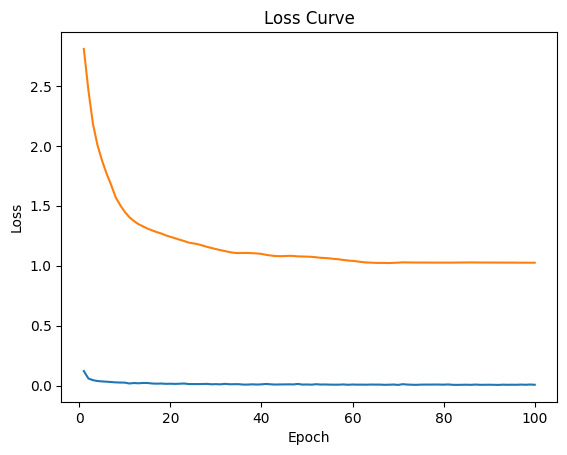

In [54]:
# Generate loss curve
plt.plot(results['epoch'], results['train_loss_bpr'], label='train')
plt.plot(results['epoch'], results['test_loss_bpr'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

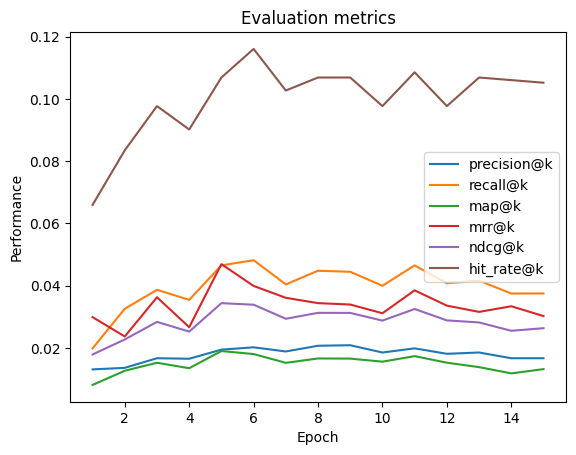

In [41]:
# Generate evaluation metrics plot
plt.plot(results['epoch'], results['precision@k'], label='precision@k')
plt.plot(results['epoch'], results['recall@k'], label='recall@k')
plt.plot(results['epoch'], results['map@k'], label='map@k')
plt.plot(results['epoch'], results['mrr@k'], label='mrr@k')
plt.plot(results['epoch'], results['ndcg@k'], label='ndcg@k')
plt.plot(results['epoch'], results['hit_rate@k'], label='hit_rate@k')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.title('Evaluation metrics')
plt.legend()
plt.show()

In [42]:
results['epoch'] = results['epoch'].astype(int)
results['train_loss_bpr'] = results['train_loss_bpr'].astype(float)
results['test_loss_bpr'] = results['test_loss_bpr'].astype(float)
results['precision@k'] = results['precision@k'].astype(float)
results['recall@k'] = results['recall@k'].astype(float)
results['map@k'] = results['map@k'].astype(float)
results['mrr@k'] = results['mrr@k'].astype(float)
results['ndcg@k'] = results['ndcg@k'].astype(float)
results['hit_rate@k'] = results['hit_rate@k'].astype(float)
results

,epoch,train_loss_bpr,test_loss_bpr,precision@k,recall@k,map@k,mrr@k,ndcg@k,hit_rate@k
0,1,0.052988,3.755193,0.013105,0.019851,0.008122,0.029891,0.017903,0.065943
1,2,0.134155,4.511513,0.013606,0.032585,0.012676,0.023679,0.022724,0.083472
2,3,0.138019,3.154776,0.016694,0.038659,0.015238,0.036277,0.028371,0.097663
3,4,0.110437,3.742528,0.016528,0.035436,0.013490,0.026653,0.025245,0.090150
4,5,0.117905,3.720767,0.019449,0.046508,0.018997,0.046916,0.034378,0.106845
5,6,0.085845,3.154994,0.020200,0.048175,0.018039,0.039910,0.033886,0.116027
6,7,0.097992,3.120713,0.018865,0.040402,0.015214,0.036097,0.029362,0.102671
7,8,0.097530,3.106915,0.020701,0.044795,0.016620,0.034385,0.031270,0.106845
8,9,0.096455,3.249215,0.020868,0.044450,0.016571,0.033941,0.031245,0.106845
9,10,0.097356,3.035160,0.018531,0.039962,0.015589,0.031137,0.028779,0.097663


In [ ]:
results.to_csv('../results/results_EuCoHT.csv')